# General Classification Explanations with G-SHAP

We can use SHAP for classification explanations. Why did our model predict that observation $x$ belongs to class $c$?

We can generalize this question using G-SHAP values. In this example, we ask two questions of the sklearn iris dataset. Suppose we have an iris $x$ which our model classifies as a Versicolour iris. We will ask:

1. Why is this observation classified as Versicolour, rather than Setosa?
2. Why is this observation classified as Versicolour, rather than Virginica?

We find that petal length is usually the most important feature. Additionally, petal length is relatively less important, and petal width relatively more important, for distinguishing Versicolour from Virginica, (as opposed to distinguishing Versicolour from Setosa).

These questions are specific examples of a general question. Define a set of positive classes $P\subset C$ and a set of negative classes $N\subset C$. For a single observation $x$, we can ask why our model predicts it belongs to a positive class rather than a negative class; $f(x)\in P \& f(x)\notin N$? For a sample $X$, we can ask which features best distinguish positive classes from negative classes.

In [1]:
import warnings
warnings.simplefilter('ignore')

import gshap
from gshap.classification import ClassificationDistance

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

We begin by loading the iris dataset and training our classifier.

In [2]:
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf = SVC(probability=True)
clf.fit(X_train, y_train)
print('Test score: % .4f' % clf.score(X_test, y_test))

Test score:  0.9737


Next, we sample observations for explanation. We select observations classified as Versicolour (class 1).

Features 2 and 3 (petal length and width) are the most important features. To visualize where our observations fall along these dimensions, we create a scatterplot. The selected observations are highlighted in red.

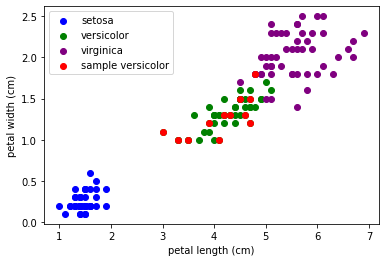

In [3]:
x = X_test[clf.predict(X_test) == 1]
x = x.reshape((1,-1)) if len(x.shape) == 1 else x
palette = ['blue', 'green', 'purple']
for i in range(3):
    species = X[y==i]
    plt.scatter(species[:,2], species[:,3], c=palette[i], label=iris.target_names[i])
plt.scatter(x[:,2], x[:,3], c='red', label='sample versicolour')
plt.xlabel(iris['feature_names'][2])
plt.ylabel(iris['feature_names'][3])
plt.legend()
plt.show()

Compute the G-SHAP values, where $g$ is `ClassificationDistance`. This measures the likelihood of observations being classified as one of the positive classes, rather than one of the negative classes.

In [4]:
# Versicolour (1) versus Setosa (0)
g = ClassificationDistance(positive_classes=[1], negative_classes=[0])
explainer = gshap.KernelExplainer(clf.predict_proba, X_train, g)
gshap_values_10 = explainer.gshap_values(x, nsamples=1000)

In [5]:
# Versicolour (1) versus Virginica (2)
g = ClassificationDistance([1], [2])
explainer = gshap.KernelExplainer(clf.predict_proba, X_train, g)
gshap_values_12 = explainer.gshap_values(x, nsamples=1000)

Finally, we display the results. This plot tells us which features best distinguish Versicolour from Setosa (blue) and which features best distinguish Versicolour from Virginia (orange).

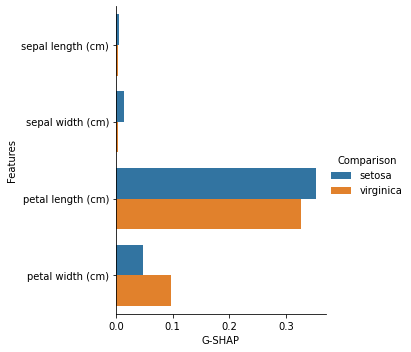

In [6]:
df = pd.DataFrame({
    'Features': iris['feature_names']*2,
    'G-SHAP': list(gshap_values_10) + list(gshap_values_12), 
    'Comparison': [iris['target_names'][0]]*4 + [iris['target_names'][2]]*4
})
sns.catplot(
    x='G-SHAP', 
    y='Features', 
    hue='Comparison', 
    data=df, 
    kind='bar',
    orient='h'
)